In [4]:
import sys
import os

# Pega o diretório de trabalho atual (que é /notebooks)
notebook_dir = os.getcwd()
# Sobe um nível para o diretório raiz do projeto
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Adiciona a raiz do projeto ao sys.path se ainda não estiver lá
if project_root not in sys.path:
    print(f"Adicionando a raiz do projeto ao path: {project_root}")
    sys.path.append(project_root)

In [5]:
from src.load_df import load_df
from joblib import load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = None

## PSI

In [6]:
# Carregar os DataFrames
df_train = load_df("../data/train.parquet")
X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']

df_test = load_df("../data/test.parquet")
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

df_val= load_df("../data/validation.parquet")
X_val = df_val.drop('inadimplente', axis=1)
y_val = df_val['inadimplente']

In [7]:
# Load the model
model = load("../models/lightgbm_optuna.joblib")['model']

- PSI < 0.1: Sem mudança significativa. A variável está estável. (Verde)
- 0.1 <= PSI < 0.25: Mudança pequena. Investigar, mas geralmente aceitável. (Amarelo)
- PSI >= 0.25: Mudança significativa. A variável está instável e pode impactar negativamente o modelo. Requer análise profunda, possível re-engenharia da feature ou até remoção. (vermelho)

In [8]:
import pandas as pd
import numpy as np

def calculate_psi(expected, actual, bins=10):
    """Calcula o Population Stability Index (PSI) para uma variável.

    Args:
        expected (pd.Series): Série de dados de referência (ex: Treino).
        actual (pd.Series): Série de dados atual (ex: OOT/Teste).
        bins (int or sequence): Número de bins (decis) ou lista com limites dos bins.
                                Para categóricas, este argumento é ignorado.

    Returns:
        float: O valor do PSI. Retorna 0 se a variável for constante.
    """
    
    # Se a variável tiver apenas um valor único, não há distribuição para comparar.
    if expected.nunique() <= 1 or actual.nunique() <= 1:
        return 0.0

    # Lida com tipos diferentes
    if pd.api.types.is_numeric_dtype(expected):
        # --- Variáveis Numéricas ---
        
        # 1. Define os BINS com base APENAS nos dados esperados (treino)
        # Usamos qcut para criar decis (quantis)
        try:
            # Garante que os limites sejam únicos
            breaks, bins_edges = pd.qcut(expected, q=bins, retbins=True, duplicates='drop')
        except ValueError:
             # Se qcut falhar (poucos valores únicos), use cut normal
            breaks, bins_edges = pd.cut(expected, bins=bins, retbins=True, duplicates='drop')

        # 2. Aplica esses mesmos BINS aos dados atuais (OOT)
        expected_binned = pd.cut(expected, bins=bins_edges, include_lowest=True)
        actual_binned = pd.cut(actual, bins=bins_edges, include_lowest=True)

        # 3. Calcula as porcentagens por bin
        df_expected_perc = expected_binned.value_counts(normalize=True).reset_index()
        df_expected_perc.columns = ['bin', 'perc_expected']

        df_actual_perc = actual_binned.value_counts(normalize=True).reset_index()
        df_actual_perc.columns = ['bin', 'perc_actual']

        # 4. Junta as porcentagens, alinhando pelos bins
        psi_df = pd.merge(df_expected_perc, df_actual_perc, on='bin', how='outer')

    else:
        # --- Variáveis Categóricas ---
        
        # 1. Calcula as porcentagens por categoria
        df_expected_perc = expected.value_counts(normalize=True).reset_index()
        df_expected_perc.columns = ['bin', 'perc_expected']

        df_actual_perc = actual.value_counts(normalize=True).reset_index()
        df_actual_perc.columns = ['bin', 'perc_actual']

        # 2. Junta as porcentagens, alinhando pelas categorias
        psi_df = pd.merge(df_expected_perc, df_actual_perc, on='bin', how='outer')

    # Evitar divisão por zero ou log de zero - Adiciona um valor muito pequeno (epsilon)
    epsilon = 1e-6
    psi_df['perc_expected'] = psi_df['perc_expected'].replace(0, epsilon)
    psi_df['perc_actual'] = psi_df['perc_actual'].replace(0, epsilon)

    # Calcula o PSI
    psi_df['psi'] = (psi_df['perc_actual'] - psi_df['perc_expected']) * np.log(psi_df['perc_actual'] / psi_df['perc_expected'])

    # Soma os componentes para obter o PSI final
    psi_value = psi_df['psi'].sum()

    return psi_value

def analyze_psi(df_train, df_test, columns_to_check=None):
    """
    Calcula e interpreta o PSI para múltiplas colunas entre treino e teste.

    Args:
        df_train (pd.DataFrame): DataFrame de treino (referência).
        df_test (pd.DataFrame): DataFrame de teste/OOT (atual).
        columns_to_check (list, optional): Lista de colunas para analisar. 
                                           Se None, analisa todas as colunas comuns.

    Returns:
        pd.DataFrame: DataFrame com o PSI e interpretação para cada coluna.
    """
    if columns_to_check is None:
        columns_to_check = [col for col in df_train.columns if col in df_test.columns]

    results = []
    print(f"Calculando PSI para {len(columns_to_check)} colunas...")

    for col in columns_to_check:
        # Pula colunas de data/ID se não foram removidas antes
        if pd.api.types.is_datetime64_any_dtype(df_train[col]) or '_id' in col.lower():
            continue
            
        psi = calculate_psi(df_train[col], df_test[col])
        
        # Interpretação
        if psi < 0.1:
            interpretation = 'Estável'
        elif psi < 0.25:
            interpretation = 'Alerta'
        else:
            interpretation = 'Instável'
            
        results.append({'Coluna': col, 'PSI': psi, 'Status': interpretation})

    psi_results_df = pd.DataFrame(results)
    psi_results_df = psi_results_df.sort_values('PSI', ascending=False) # Ordena para ver os piores primeiro

    return psi_results_df

In [9]:
features_names = X_train.columns.tolist()

psi_results_df = analyze_psi(X_train, X_test)

psi_results_warning = psi_results_df[psi_results_df['Status'] != 'Estável']
display(psi_results_warning)

Calculando PSI para 62 colunas...


,Coluna,PSI,Status
55,data_decisao_ano,15.872274,Instável
22,num_emp_aceitos_6m,2.373671,Instável
56,data_decisao_mes,1.971124,Instável
21,num_emp_aceitos_3m,1.564704,Instável
24,atraso_medio_6m,0.534709,Instável
23,atraso_medio_3m,0.423842,Instável
59,inter_valor_credito_x_valor_bem,0.283080,Instável
3,valor_credito,0.278724,Instável
4,valor_bem,0.263887,Instável
58,ratio_credito_renda,0.244412,Alerta


In [10]:
def calculate_scores(model, df):
    y_pred_proba = model.predict_proba(df)[:, 1]
    scores = 1000 - (y_pred_proba * 1000).astype(int)

    return scores

In [11]:
credit_scores = calculate_scores(model, X_test.drop('data_decisao_ano', axis=1))

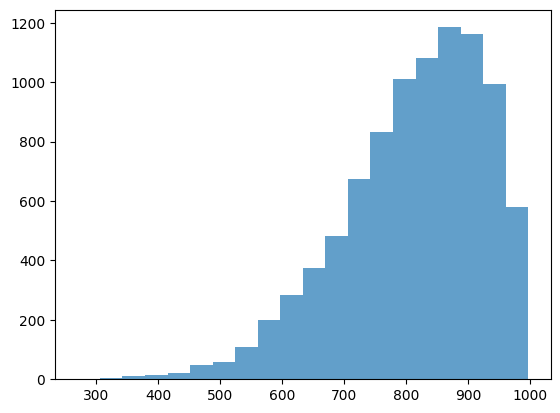

In [12]:
plt.hist(credit_scores, bins=20, alpha=0.7)
plt.show()

## Criação da variável safra

In [13]:
ano_str = X_test['data_decisao_ano'].astype(str)
mes_str = X_test['data_decisao_mes'].astype(str)

# garante que o mês tenha sempre dois dígitos 
mes_formatado = mes_str.str.zfill(2)

# concatena as strings para criar a safra no formato 'YYYY-MM'
X_test['safra'] = ano_str + '-' + mes_formatado

# verifica o resultado
print("Coluna 'safra' criada com sucesso. Amostra:")
display(X_test[['safra', 'data_decisao_ano', 'data_decisao_mes']].head())

Coluna 'safra' criada com sucesso. Amostra:


,safra,data_decisao_ano,data_decisao_mes
0,2023-07,2023,7
1,2023-07,2023,7
2,2023-07,2023,7
3,2023-07,2023,7
4,2023-07,2023,7


## Análise de Ranqueamento

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import string # Para gerar as letras A, B, C...

def analyze_score_bins_custom(credit_scores, y_test, bins_edges=None, num_bins=10):
    """
    Divide os scores de crédito em bins, calcula estatísticas e adiciona rótulos A, B, C...
    (A = melhor faixa de score).
    """
    
    df_analysis = pd.DataFrame({
        'score': credit_scores,
        'inadimplente_real': y_test
    })

    # --- Lógica de Binning (igual à anterior) ---
    if bins_edges is not None:
        print(f"Usando bins customizados: {bins_edges}")
        labels = [f'{int(bins_edges[i])}-{int(bins_edges[i+1])-1}' for i in range(len(bins_edges)-1)]
        labels[-1] = f'{int(bins_edges[-2])}-{int(bins_edges[-1])}'
        df_analysis['score_bin_range'] = pd.cut(df_analysis['score'], bins=bins_edges, labels=labels,
                                                include_lowest=True, right=True)
        df_analysis.dropna(subset=['score_bin_range'], inplace=True)
    else:
        print(f"Usando {num_bins} bins automáticos (quantis).")
        try:
            df_analysis['score_bin_num'], bin_edges_qcut = pd.qcut(df_analysis['score'], q=num_bins, labels=False, retbins=True, duplicates='drop')
        except ValueError as e:
            print(f"Aviso: Não foi possível criar {num_bins} bins distintos. {e}")
            df_analysis['score_bin_num'], bin_edges_qcut = pd.qcut(df_analysis['score'], q=num_bins, labels=False, retbins=True, duplicates='raise')
            
        bin_edges_qcut = [int(round(b)) for b in bin_edges_qcut]
        labels = [f'{bin_edges_qcut[i]}-{bin_edges_qcut[i+1]-1}' for i in range(len(bin_edges_qcut)-1)]
        labels[-1] = f'{bin_edges_qcut[-2]}-{bin_edges_qcut[-1]}'
        label_map = {i: labels[i] for i in range(len(labels))}
        df_analysis['score_bin_range'] = df_analysis['score_bin_num'].map(label_map)
        df_analysis.drop(columns=['score_bin_num'], inplace=True)

    # --- Calcular Estatísticas (igual à anterior) ---
    stats_per_bin = df_analysis.groupby('score_bin_range', observed=False).agg(
        score_medio=('score', 'mean'),
        score_min=('score', 'min'),
        score_max=('score', 'max'),
        volume=('score', 'count'),
        taxa_inadimplencia_real=('inadimplente_real', 'mean')
    ).reset_index()

    # Ordena pelos scores mínimos (pior para melhor risco)
    stats_per_bin = stats_per_bin.sort_values('score_min').reset_index(drop=True)
    stats_per_bin['score_medio'] = stats_per_bin['score_medio'].round(1)

    # --- NOVO: Adicionar Rótulos A, B, C... ---
    # Gera as letras do alfabeto (A, B, C, ...)
    num_actual_bins = len(stats_per_bin)
    score_labels = list(string.ascii_uppercase[:num_actual_bins])
    
    # Atribui as letras em ordem INVERSA, para que 'A' seja o melhor score (última linha)
    stats_per_bin['score_label'] = score_labels[::-1] 
    
    # Reordena as colunas para melhor visualização
    stats_per_bin = stats_per_bin[['score_label', 'score_bin_range', 'score_min', 'score_max', 'score_medio', 'volume', 'taxa_inadimplencia_real']]

    return stats_per_bin

def plot_score_bins_analysis(stats_per_bin):
    """
    Plota o gráfico de análise de bins de score usando os rótulos A, B, C...
    e adiciona uma legenda explicativa.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(14, 8)) # Aumentei um pouco o tamanho

    # Ordena para plotar do pior (J/I/H...) para o melhor (A)
    plot_data = stats_per_bin.sort_values('score_min').reset_index(drop=True)

    # Eixo 1: Taxa de Inadimplência Real (Barras)
    bars = ax1.bar(plot_data['score_label'], plot_data['taxa_inadimplencia_real'], color='skyblue', label='Taxa de Inadimplência Real')
    # NOVO: Label do eixo X com os rótulos
    ax1.set_xlabel('Faixa de Score (A = Melhor Risco / Score Mais Alto)', fontsize=12) 
    ax1.set_ylabel('Taxa de Inadimplência Real (%)', fontsize=12, color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    # ax1.set_xticks(plot_data.index) # Usa o índice numérico para os ticks
    # ax1.set_xticklabels(plot_data['score_label']) # Define os labels como as letras
    ax1.bar_label(bars, fmt='{:.1%}', padding=3)

    plt.title('Análise da Taxa de Inadimplência Real por Faixa de Score', fontsize=16, pad=20)

    # --- NOVO: Criar e adicionar a legenda ---
    legend_text = "Legenda das Faixas:\n" + "\n".join(
        [f"{row['score_label']}: {row['score_bin_range']}" for index, row in plot_data.iterrows()]
    )
    # Adiciona a legenda como texto na figura (fora dos eixos)
    fig.text(0.92, 0.5, legend_text, fontsize=10, va='center', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    fig.tight_layout(rect=[0, 0, 0.9, 1]) # Ajusta layout para dar espaço à legenda
    plt.show()

Usando bins customizados: [0, 500, 700, 850, 950, 1000]
--- Estatísticas por Faixa de Score ---


,score_label,score_bin_range,score_min,score_max,score_medio,volume,taxa_inadimplencia_real
0,E,0-499,270,499,442.4,113,0.008850
1,D,500-699,502,700,632.5,1417,0.007763
2,C,700-849,701,850,784.2,3646,0.003291
3,B,850-949,851,950,899.1,3149,0.002540
4,A,950-1000,951,997,969.1,805,0.002484


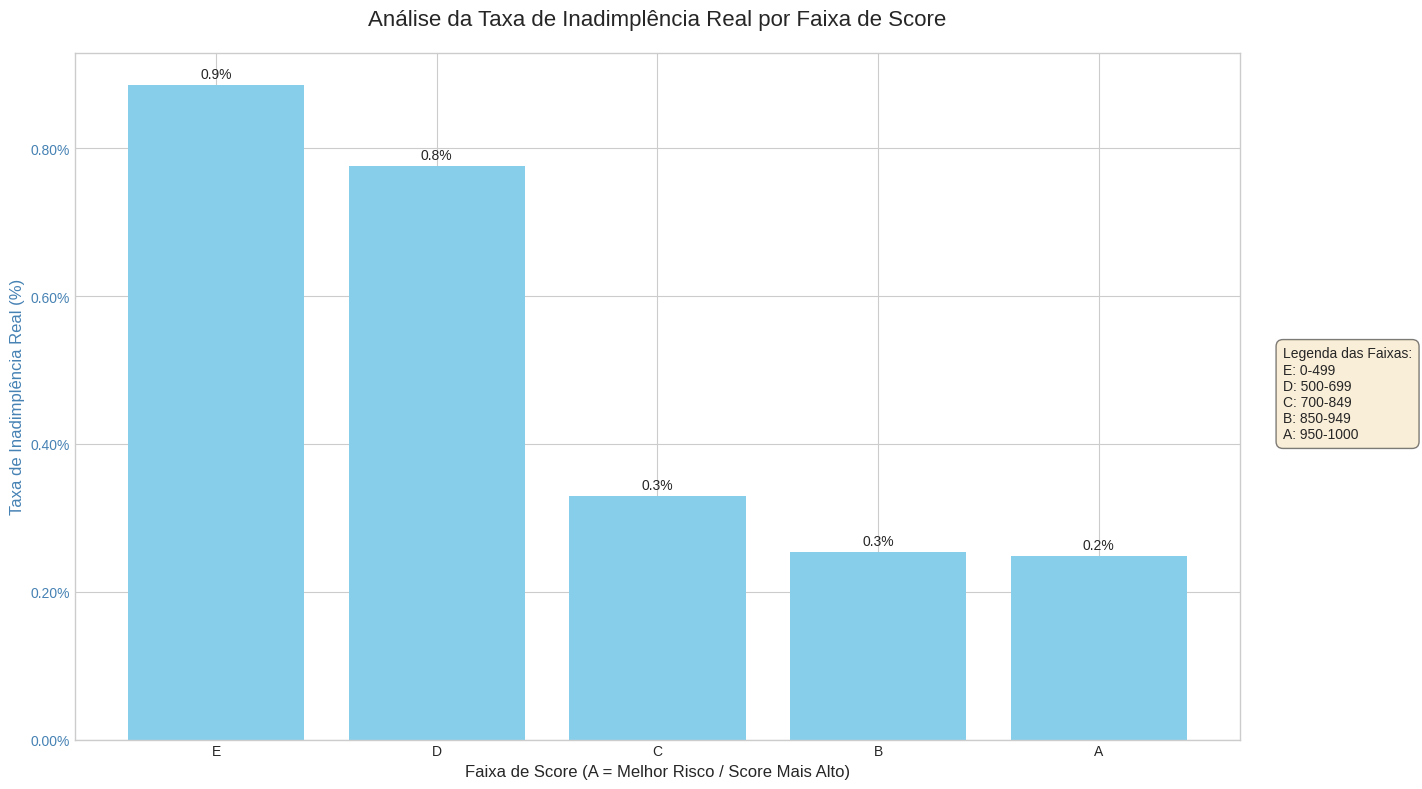

In [15]:
bins_edges = [0, 500, 700, 850, 950, 1000]

stats_df = analyze_score_bins_custom(credit_scores, y_test, bins_edges=bins_edges)

# 3. Exiba a tabela de estatísticas
print("--- Estatísticas por Faixa de Score ---")
display(stats_df)

# 4. Plote o gráfico
plot_score_bins_analysis(stats_df)

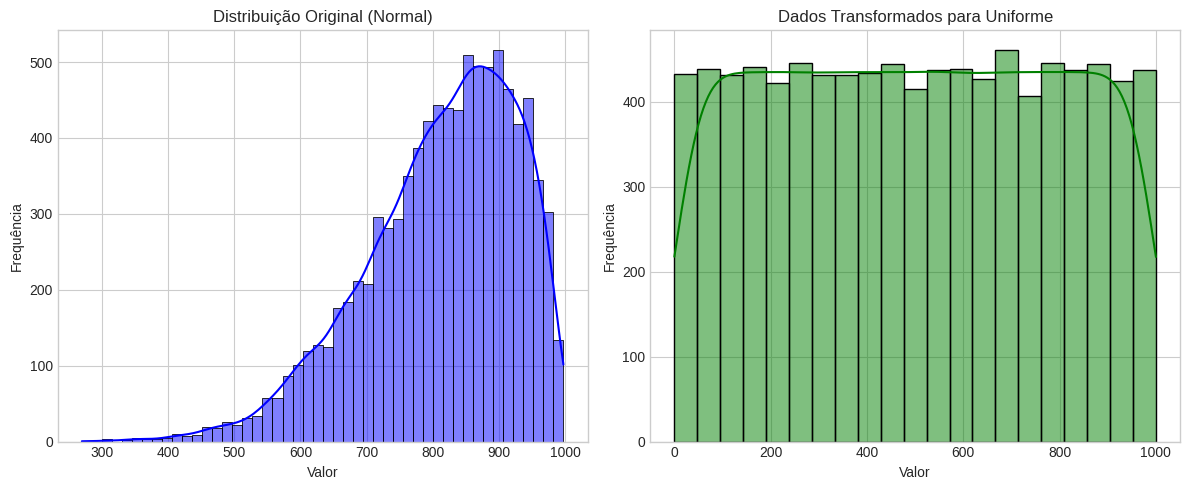

In [16]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='uniform', random_state=0)

credit_scores_uniformed = qt.fit_transform(credit_scores.reshape(-1, 1))

# 4. Visualizar os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma dos dados originais (normais)
sns.histplot(credit_scores, kde=True, ax=ax1, color='blue')
ax1.set_title('Distribuição Original (Normal)')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')

credit_scores_uniformed = credit_scores_uniformed.flatten()*1000

# Histograma dos dados transformados (uniformes)
sns.histplot(credit_scores_uniformed, kde=True, ax=ax2, color='green')
ax2.set_title('Dados Transformados para Uniforme')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

Usando 5 bins automáticos (quantis).
--- Estatísticas por Faixa de Score ---


,score_label,score_bin_range,score_min,score_max,score_medio,volume,taxa_inadimplencia_real
0,E,0-199,0.000000,199.699700,100.3,1833,0.008183
1,D,200-400,201.201201,400.900901,301.9,1848,0.002706
2,C,401-597,404.904905,598.098098,501.8,1801,0.002776
3,B,598-800,601.601602,800.800801,701.3,1840,0.001087
4,A,801-1000,803.803804,1000.000000,901.0,1808,0.003872


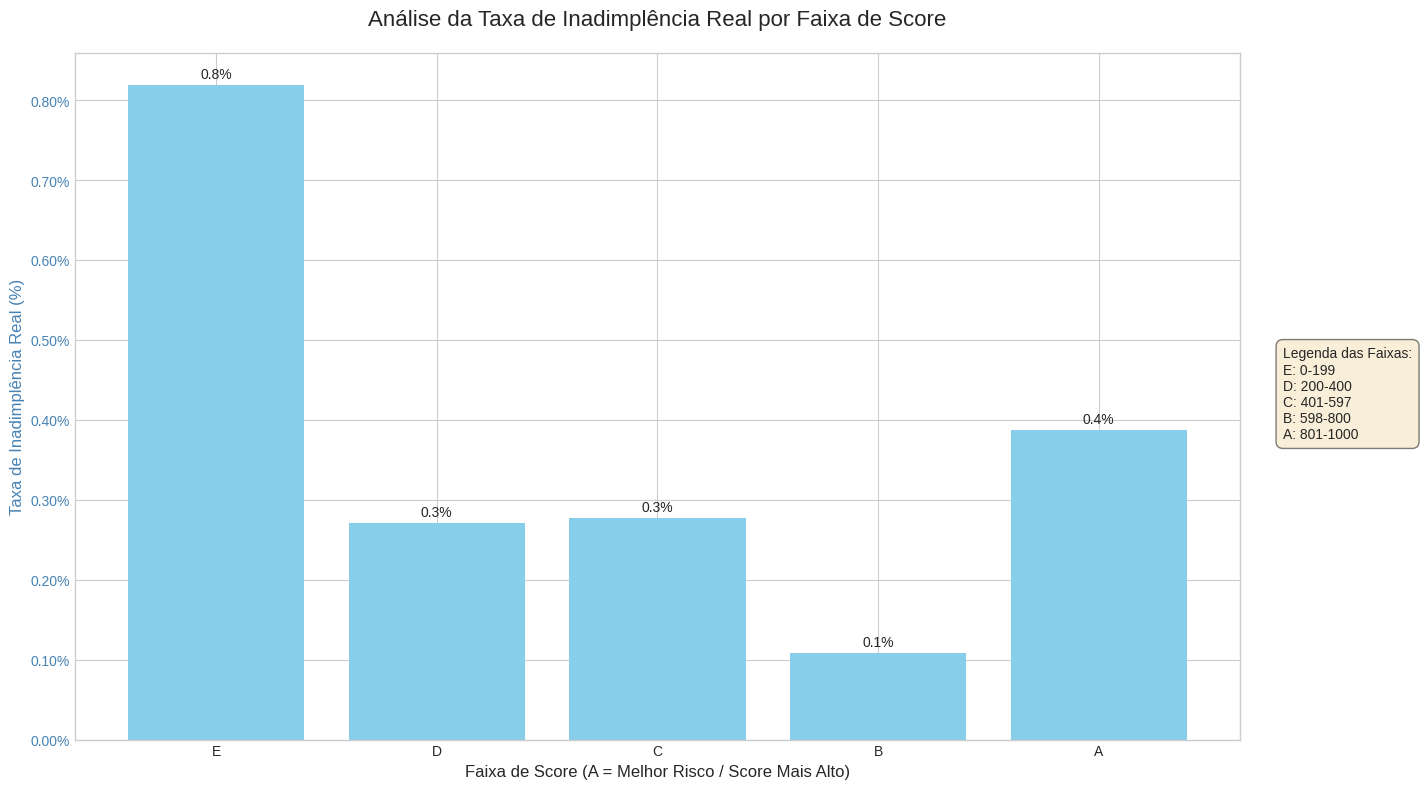

In [17]:
num_bins = 5

stats_df = analyze_score_bins_custom(credit_scores_uniformed, y_test, num_bins=num_bins)

print("--- Estatísticas por Faixa de Score ---")
display(stats_df)

plot_score_bins_analysis(stats_df)

Usando bins customizados: [0, 100, 200, 400, 650, 900, 1000]
--- Estatísticas por Faixa de Score ---


,score_label,score_bin_range,score_min,score_max,score_medio,volume,taxa_inadimplencia_real
0,F,0-99,0.000000,99.099099,49.9,913,0.007667
1,E,100-199,100.600601,199.699700,150.3,920,0.008696
2,D,200-399,201.201201,397.897898,300.0,1812,0.002759
3,C,400-649,400.900901,648.648649,524.7,2291,0.003055
4,B,650-899,652.652653,898.898899,775.4,2286,0.002187
5,A,900-1000,901.901902,1000.000000,950.3,908,0.002203


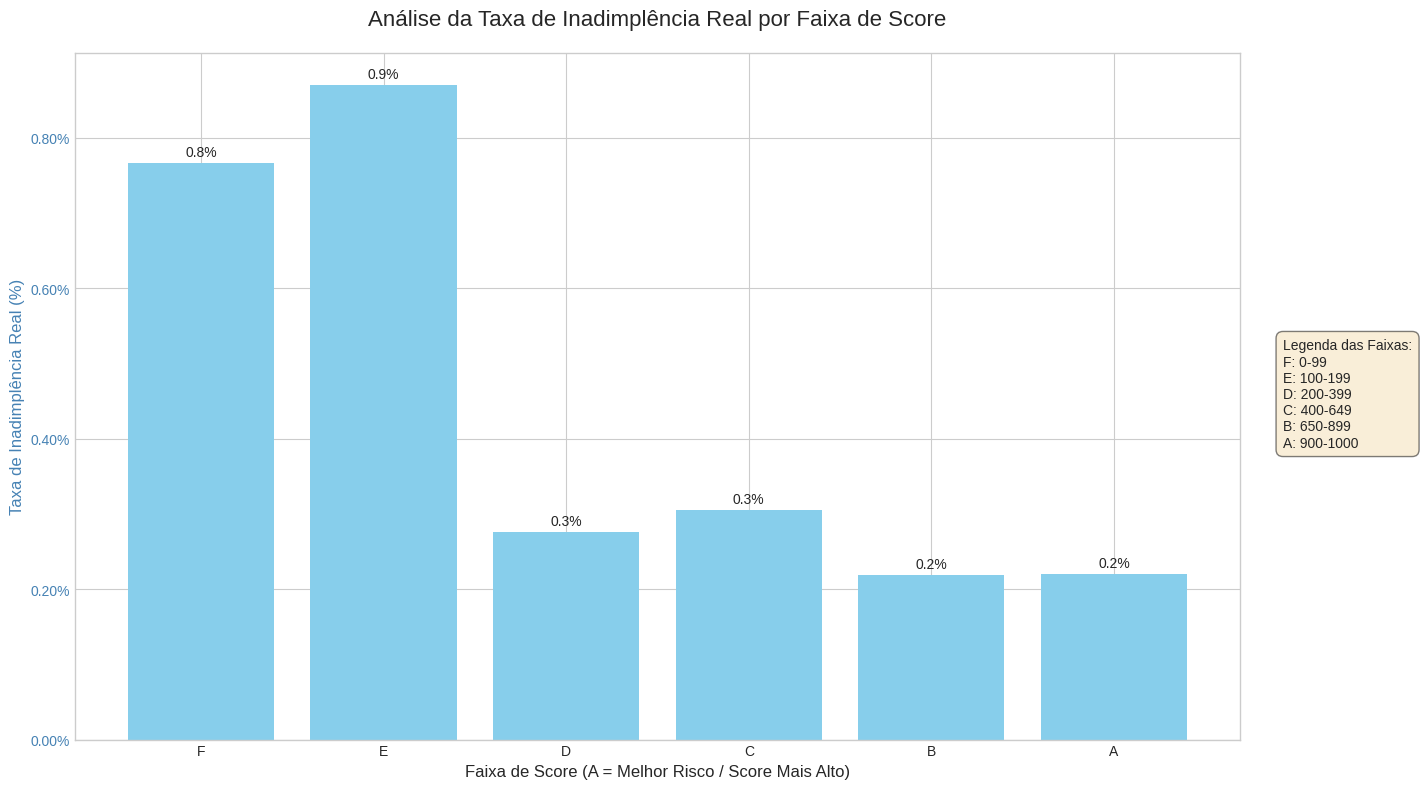

In [18]:
bins_edges = [0, 100, 200, 400, 650, 900, 1000]

stats_df = analyze_score_bins_custom(credit_scores_uniformed, y_test, bins_edges=bins_edges)

# 3. Exiba a tabela de estatísticas
print("--- Estatísticas por Faixa de Score ---")
display(stats_df)

# 4. Plote o gráfico
plot_score_bins_analysis(stats_df)

In [19]:
safra_test = X_test['data_decisao_mes']

In [20]:
import pandas as pd
import numpy as np
import string

def assign_score_labels(credit_scores, bins_edges=None, num_bins=10):
    """
    Atribui rótulos de faixa de score (A, B, C...) a uma série de scores.
    'A' representa a faixa de score mais alta (melhor risco).

    Args:
        credit_scores (pd.Series or np.array): Scores de crédito calculados.
        bins_edges (list or None): Lista com os limites das faixas de score.
                                   Se None, usa quantis automáticos (num_bins).
        num_bins (int): Número de quantis a serem criados se bins_edges for None.

    Returns:
        pd.Series: Série contendo o rótulo da faixa ('A', 'B', ...) para cada score.
    """
    df_temp = pd.DataFrame({'score': credit_scores})
    num_actual_bins = 0

    if bins_edges is not None:
        num_actual_bins = len(bins_edges) - 1
        # Cria labels numéricos temporários (0 a N-1)
        df_temp['bin_num'] = pd.cut(df_temp['score'], bins=bins_edges, labels=False,
                                    include_lowest=True, right=True, duplicates='drop')
    else:
        num_actual_bins = num_bins
        try:
            df_temp['bin_num'] = pd.qcut(df_temp['score'], q=num_bins, labels=False, duplicates='drop')
        except ValueError:
            # Se qcut falhar, pode retornar menos bins
             df_temp['bin_num'] = pd.qcut(df_temp['score'], q=num_bins, labels=False, duplicates='raise')
             num_actual_bins = df_temp['bin_num'].nunique() # Atualiza o número real de bins

    # Gera as letras (A, B, C...)
    score_labels_list = list(string.ascii_uppercase[:num_actual_bins])
    
    # Cria o mapeamento: bin numérico -> Letra (invertido, 0=pior -> J, 9=melhor -> A)
    # Ordenamos os bins numéricos do maior para o menor score antes de mapear
    label_map = {bin_num: score_labels_list[i] for i, bin_num in enumerate(sorted(df_temp['bin_num'].unique(), reverse=True))}
    
    # Aplica o mapeamento para obter a coluna final de rótulos
    score_label_series = df_temp['bin_num'].map(label_map)
    
    return score_label_series

In [26]:
X_test['safra'].value_counts()

,dia_semana_solicitacao,hora_solicitacao,tipo_contrato,valor_credito,valor_bem,valor_parcela,qtd_filhos,qtd_membros_familia,renda_anual,tipo_renda,...,hist_valor_parcela_6m_max,hist_valor_parcela_6m_sum,data_decisao_ano,data_decisao_mes,data_decisao_dia_do_mes,ratio_credito_renda,inter_valor_credito_x_valor_bem,inter_valor_credito_x_valor_parcela,inter_valor_bem_x_valor_parcela,safra
0,5,8,2,1277104.500,1129500.000,47189.025,0,2.0,202500.0,4,...,0.0,0.0,2023,7,12,6.306689,1.442490e+12,6.026532e+10,5.330000e+10,2023-07
1,5,16,2,384948.000,360000.000,30865.140,1,3.0,247500.0,4,...,0.0,0.0,2023,7,12,1.555345,1.385813e+11,1.188147e+10,1.111145e+10,2023-07
2,5,7,2,328450.500,270000.000,11797.920,0,2.0,90000.0,2,...,0.0,0.0,2023,7,12,3.649450,8.868164e+10,3.875033e+09,3.185438e+09,2023-07
3,5,13,3,119340.000,119340.000,11139.210,0,2.0,121500.0,4,...,0.0,0.0,2023,7,12,0.982222,1.424204e+10,1.329353e+09,1.329353e+09,2023-07
4,5,10,2,96076.845,90127.845,9599.985,0,1.0,99000.0,2,...,0.0,0.0,2023,7,12,0.970473,8.659199e+09,9.223363e+08,8.652260e+08,2023-07


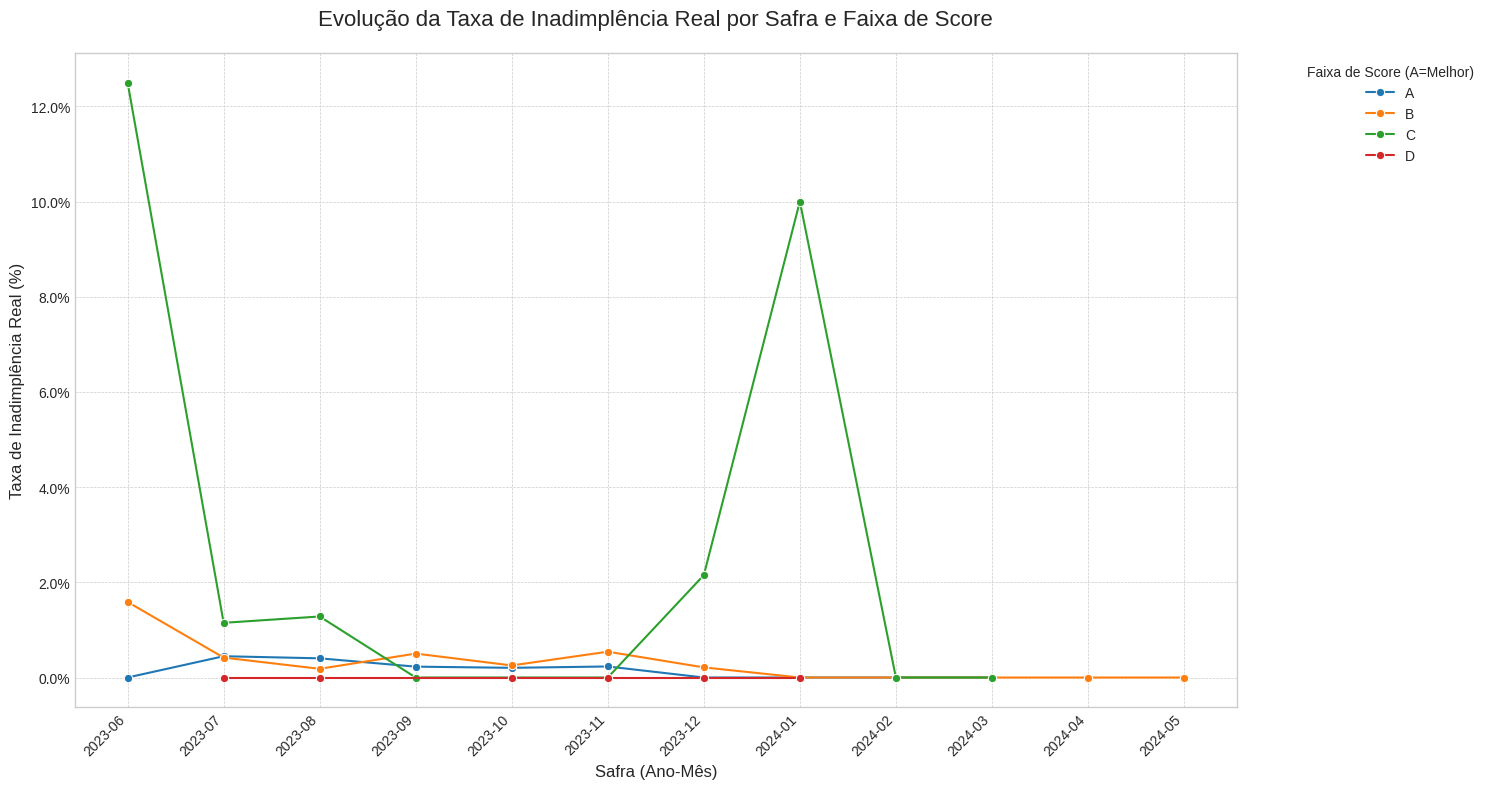

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

def plot_default_rate_over_time_by_score_band(X_test_with_safra, y_test, score_labels):
    """
    Plota a taxa de inadimplência real ao longo do tempo (safra) para cada faixa de score.

    Args:
        X_test_with_safra (pd.DataFrame): DataFrame de teste contendo a coluna 'safra'.
        y_test (pd.Series or np.array): Valores reais da variável target para o teste.
        score_labels (pd.Series): Série com os rótulos ('A', 'B', ...) para cada registro em X_test.
    """
    
    # 1. Combinar os dados necessários
    df_plot = pd.DataFrame({
        'safra': X_test_with_safra['safra'],
        'score_label': score_labels,
        'inadimplente_real': y_test
    })

    # 2. Calcular a taxa de inadimplência por safra e por faixa de score
    # Usamos observed=False para garantir que todas as faixas apareçam mesmo se vazias em alguma safra
    default_rate_over_time = df_plot.groupby(['safra', 'score_label'], observed=False)['inadimplente_real'].mean().reset_index()

    # Ordena para garantir que as safras e labels estejam na ordem correta
    default_rate_over_time = default_rate_over_time.sort_values(['safra', 'score_label'])

    # 3. Plotar o gráfico de linhas
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    ax = sns.lineplot(
        data=default_rate_over_time,
        x='safra',
        y='inadimplente_real',
        hue='score_label', # Uma linha para cada faixa de score
        marker='o',
        # palette='viridis_r' # Exemplo de paleta de cores (opcional)
    )

    # Melhorar a formatação
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    plt.title('Evolução da Taxa de Inadimplência Real por Safra e Faixa de Score', fontsize=16, pad=20)
    plt.xlabel('Safra (Ano-Mês)', fontsize=12)
    plt.ylabel('Taxa de Inadimplência Real (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Faixa de Score (A=Melhor)', bbox_to_anchor=(1.05, 1), loc='upper left') # Legenda fora do gráfico
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

credit_scores = calculate_scores(model, X_test.drop(columns = ['safra', 'data_decisao_ano'], axis=1))

score_label_series = assign_score_labels(credit_scores, bins_edges=bins_edges)

plot_default_rate_over_time_by_score_band(X_test, y_test, score_label_series)

## AUC por Safra

In [20]:
def plot_auc_over_time(model, dataframe, y_test):
    """
    Calcula e plota o AUC do modelo para cada safra no conjunto de teste.

    Args:
        model: O modelo treinado.
        dataframe (pd.DataFrame): DataFrame de teste com as features finais (numéricas).
        y_test (pd.Series or np.array): Valores reais da variável target para o teste.
    """
    print("Calculando AUC por safra...")

    # 1. Obter as probabilidades previstas
    try:
        y_pred_proba = model.predict_proba(dataframe)[:, 1]
    except ValueError as e:
        print(f"Erro ao prever probabilidades: {e}")
        print("Verifique se dataframe contém apenas as colunas numéricas esperadas pelo modelo.")
        # Tenta prever usando apenas colunas que o modelo conhece, se disponível
        if hasattr(model, 'feature_name_') or hasattr(model, 'feature_names_in_'):
            training_cols = model.feature_name_ if hasattr(model, 'feature_name_') else model.feature_names_in_
            missing_cols = set(training_cols) - set(dataframe.columns)
            if missing_cols:
                 print(f"Colunas faltando em dataframe: {missing_cols}")
                 return
            try:
                y_pred_proba = model.predict_proba(dataframe[training_cols])[:, 1]
            except Exception as inner_e:
                print(f"Erro mesmo após seleção de colunas: {inner_e}")
                return
        else:
            return


    # 2. Combinar dados
    df_auc_analysis = pd.DataFrame({
        'safra': dataframe['safra'],
        'y_real': y_test,
        'probabilidade_inadimplencia': y_pred_proba
    })

    # 3. Calcular AUC por safra
    auc_per_safra = []
    safras = sorted(df_auc_analysis['safra'].unique())

    for s in safras:
        df_safra = df_auc_analysis[df_auc_analysis['safra'] == s]
        
        # Verifica se há ambas as classes (0 e 1) na safra para calcular AUC
        if len(df_safra['y_real'].unique()) < 2:
            print(f"Aviso: Safra {s} tem apenas uma classe. AUC não pode ser calculado, será NaN.")
            auc_score = np.nan
        else:
            auc_score = roc_auc_score(df_safra['y_real'], df_safra['probabilidade_inadimplencia'])
            
        auc_per_safra.append({'safra': s, 'auc': auc_score})

    df_auc_results = pd.DataFrame(auc_per_safra)

    print("\n--- AUC por Safra ---")
    display(df_auc_results)

    # 4. Plotar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))

    plt.plot(df_auc_results['safra'], df_auc_results['auc'], marker='o', linestyle='-', color='dodgerblue')

    # Calcular e plotar AUC médio (ignorando NaNs)
    auc_medio = df_auc_results['auc'].mean()
    plt.axhline(auc_medio, color='grey', linestyle='--', label=f'AUC Médio = {auc_medio:.4f}')

    # Formatação
    plt.title('Evolução do AUC por Safra (Teste OOT)', fontsize=16, pad=20)
    plt.xlabel('Safra (Ano-Mês)', fontsize=12)
    plt.ylabel('AUC-ROC', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=max(0, df_auc_results['auc'].min() - 0.05), top=min(1, df_auc_results['auc'].max() + 0.05)) # Ajusta limites do eixo Y
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

Calculando AUC por safra...
Erro ao prever probabilidades: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: safra: object
Verifique se dataframe contém apenas as colunas numéricas esperadas pelo modelo.


Aviso: Safra 2024-02 tem apenas uma classe. AUC não pode ser calculado, será NaN.
Aviso: Safra 2024-03 tem apenas uma classe. AUC não pode ser calculado, será NaN.
Aviso: Safra 2024-04 tem apenas uma classe. AUC não pode ser calculado, será NaN.
Aviso: Safra 2024-05 tem apenas uma classe. AUC não pode ser calculado, será NaN.

--- AUC por Safra ---


,safra,auc
0,2023-06,0.873684
1,2023-07,0.624602
2,2023-08,0.577453
3,2023-09,0.681159
4,2023-10,0.538567
5,2023-11,0.520674
6,2023-12,0.907381
7,2024-01,0.961538
8,2024-02,NaN
9,2024-03,NaN


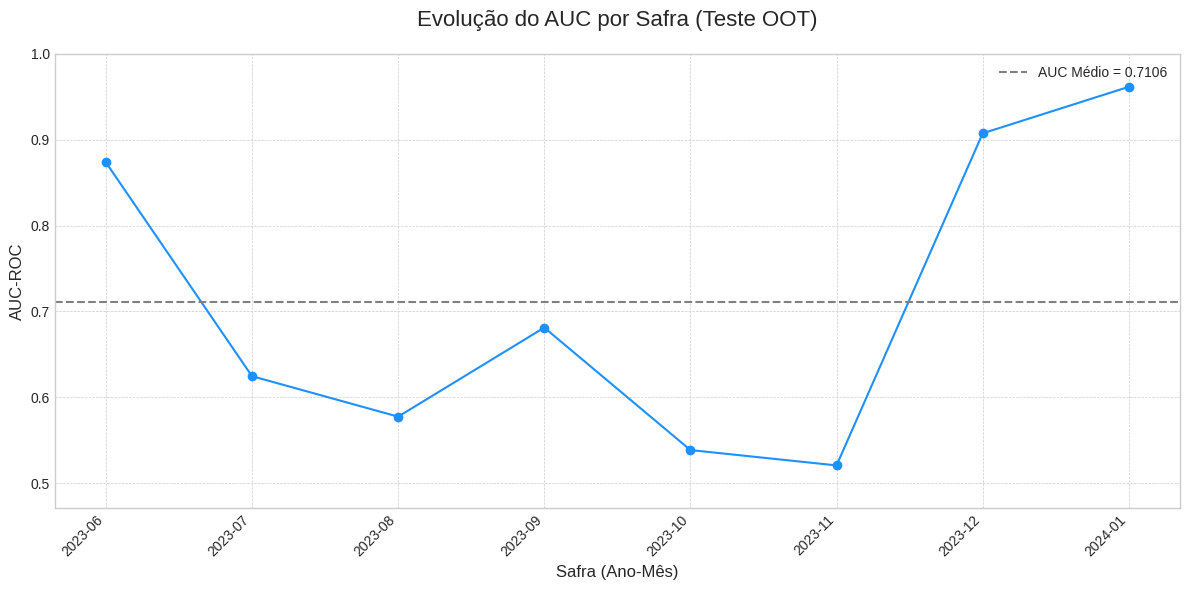

In [23]:
X_test_processed = X_test.drop(columns = ['data_decisao_ano'], axis=1)
plot_auc_over_time(model, X_test_processed, y_test)